# Fake 3d maps with fake seeing/non-periodic 

+ Load moment 1 maps from fake-maps-seeing-nonp-3dfields-create
+ Calculate and export structure functions
+ Investigate the effect on the structure function


In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path
import numpy as np
import json
from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
import cmasher as cmr
from matplotlib import pyplot as plt
import turbustat.statistics as tss
import turbustat.simulator
#from turbustat.simulator import make_3dfield
from turb_utils import make_extended
import seaborn as sns
import sys
from turbustat.simulator import make_ppv
from turb_utils import make_extended, make_3dfield
from spectral_cube import SpectralCube  

from astropy.convolution import Gaussian2DKernel, convolve_fft

sys.path.append("../structure-functions")

import strucfunc

sns.set_color_codes()
sns.set_context("talk")

In [3]:
def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

In [4]:
widths = [1, 2, 4, 8, 16, 32]
r0 = 32.0
N = 256
m = 1.0

Load non-periodic maps

In [13]:
maps_moment1 = json.load(open("v_maps_3ds.json"))


In [14]:
vms = np.array(maps_moment1['0'])
vms_t = np.array(maps_moment1['1'])

In [15]:
vmap_nps = {}
vmap_nps[1] = np.array(maps_moment1['2']['1'])
vmap_nps[2] = np.array(maps_moment1['2']['2'])
vmap_nps[4] = np.array(maps_moment1['2']['4'])
vmap_nps[8] = np.array(maps_moment1['2']['8'])
vmap_nps[16] = np.array(maps_moment1['2']['16'])
vmap_nps[32] = np.array(maps_moment1['2']['32'])

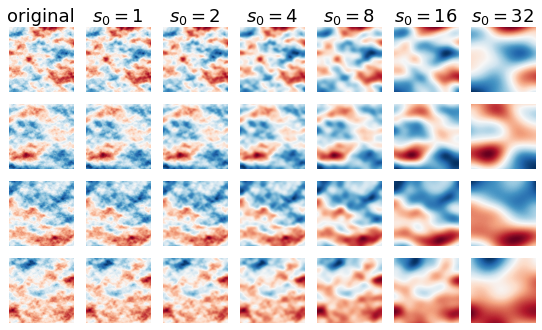

In [16]:
imshow_kwds = dict(origin="lower", cmap="RdBu_r")


ncols = len(widths) + 1
nrows = 4
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(8, 5.1),
    sharex=True,
    sharey=True,
)
for j, vm in enumerate(vms_t):
    im = axes[j, 0].imshow(vm, **imshow_kwds)
axes[0, 0].set_title("original")
for i, width in enumerate(widths):
    for j, vm in enumerate(vmap_nps[width]):
        im = axes[j, i + 1].imshow(vm, **imshow_kwds)
    axes[0, i + 1].set_title(fr"$s_0 = {width}$")

for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
sns.despine(left=True, bottom=True)
fig.tight_layout(h_pad=0.2, w_pad=0.2)


The velocity maps look the same as the notebook 'fake-maps-seeing-nonp-3dfields-create' so the export/import works

Computations of the structure functions for non-tapered non-smoothed maps.

In [18]:
#vms = [normalize(_) for _ in vms]
#vms_t = [normalize(_) for _ in vms_t]
#for width in widths:
#    vmap_nps[width] = [normalize(_) for _ in vmap_nps[width]]



In [19]:
sfs_np = [strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05) for vm in vms]

C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:82: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [65]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [96]:
for i in range(0,4,1):

    sfs_np[i]['Unweighted sigma^2'] = vms[i].var()
    sfs_np[i]['Apparent r0'] = np.interp(vms[i].var(), 
                                        sfs_np[i]["Unweighted B(r)"][mask], 
                                        10**sfs_np[i]['log10 r'][mask])

    jsonfilename = "fake-non-tapered-3d-nonp-nn-s0-000-0" + str(i) + "-strucfunc.json"
    with open(jsonfilename, "w") as f:
        json.dump(sfs_np[i], fp=f, indent=3, cls=MyEncoder)

Computations of the structure functions for tapered non-smoothed maps.

In [21]:
sfs_npt = [strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05) for vm in vms_t]

C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:82: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [95]:
for i in range(0,4,1):

    sfs_npt[i]['Unweighted sigma^2'] = vms_t[i].var()
    sfs_npt[i]['Apparent r0'] = np.interp(vms_t[i].var(), 
                                        sfs_npt[i]["Unweighted B(r)"][mask], 
                                        10**sfs_npt[i]['log10 r'][mask])

    jsonfilename = "fake-tapered-3d-nonp-nn-s0-000-0" + str(i) + "-strucfunc.json"
    with open(jsonfilename, "w") as f:
        json.dump(sfs_npt[i], fp=f, indent=3, cls=MyEncoder)

In [23]:
def values2arrays(d):
    for k in d.keys():
        if type(d[k]) == list:
            d[k] = np.array(d[k])
    return d

Computations of the structure functions for tapered smoothed maps.

Try and load the structure function from JSON files.  If that fails, then recalculate the structure functions and save to JSON files.

In [24]:
use_cached_strucfunc = False

In [25]:
if use_cached_strucfunc:
    sfs_npt_s = {
        width: [
            values2arrays(json.load(open(fn)))
            for fn in sorted(
                Path(".").glob(f"fake-tapered-3d-nonp-nn-s0-{width:03d}-*-strucfunc.json")
            )
        ]
        for width in widths
    }
else:
    sfs_npt_s = {
        width: [
            strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05) for vm in vmap_nps[width]
        ]
        for width in widths
    }
    for width in widths:
        for jj, (_sf, _vm) in enumerate(zip(sfs_npt_s[width], vmap_nps[width])):
            jsonfilename = f"fake-tapered-3d-nonp-nn-s0-{width:03d}-{jj:02d}-strucfunc.json"
            sig2 = _sf["Unweighted sigma^2"] = np.var(_vm)
            B = _sf["Unweighted B(r)"][mask]
            true_r0 = _sf["Apparent r0"] = np.interp(sig2, B[:-4], r[:-4])
            with open(jsonfilename, "w") as f:
                json.dump(_sf, fp=f, indent=3, cls=JsonCustomEncoder)

C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Documents\Aeon\GitHub\PhD.Paper\Fake-Maps\strucfunc.py:82: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [118]:
!jupyter nbconvert --to script --no-prompt fake-3d-maps-seeing-nonp-sosf-computation.ipynb

[NbConvertApp] Converting notebook fake-3d-maps-seeing-nonp-sosf-computation.ipynb to script
[NbConvertApp] Writing 5571 bytes to fake-3d-maps-seeing-nonp-sosf-computation.py


In [31]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 1111.0241072177887 seconds ---
